# Mini-projet groupe 2 : interpolation de données manquantes
Contexte : dans le cadre d'acquisition de données sismiques, des capteurs (récepteurs) sont positionnés le long d'une ligne à la surface de la terre. Chacun enregistre au cours du temps le deplacement des particules (signal oscillant) qui varie lors du passage d'une onde acoustique ou élastique. Cet enregistrement s'appelle une **trace**.

En pratique, il arrive que certains capteurs sont défaillants ou encore qu'ils ne sont pas présents dans certaines zones (pour des problèmes d'accessibilité par exemple). L'objectif principal du mini-projet est de reconstituer les traces manquantes.

Hypotheses : nous ferons l'hypothèse importante que les **signaux correspondent à la superposition lineaire d'ondes planes** dans les enregistrements (voir l'exemple fourni plus bas avec 3 événements).

Notions abordées : 
* Analyse des signaux après transformée de Fourier 2d
* Analyse de signaux aliasés
* Régularisation et formulation sous forme de problème inverse

Pour cela, deux approches sont considerées :
* Approche 1 : transformée de Fourier 2d, identification des événements principaux, définition d'un masque et reconstitution des traces manquantes
* Approche 2 : suite de l'approche 1 pour s'assurer que la prédiction respecte bien les observables. Elle se fait au travers de la résolution d'un problème inverse avec ajout de régularisation

Attentes :
* Développement des approches 1 et 2 sur des données fournies ici
* Discusssion des limites des approches sur des exemples que vous pourrez créer vous-mêmes

Consignes :
* **Très important** : pour toutes les figures, bien indiquer les axes avec les bonnes unités et des labels de taille lisibles

In [2]:
import numpy as np
import matplotlib.pyplot as plt
# Pour la question 4
from scipy.optimize import minimize

from mpl_toolkits.mplot3d import Axes3D

In [3]:
# Labelsize (display)
labelsize   = 14
    
# Load the input data
# Input data (with missing traces)
gpanel = np.load('gpanel.npy')
# Dense data (with all traces, only for comparison)
panel_dense = np.load('panel_dense.npy')
nt, nx = gpanel.shape

# Vertical axis -- time
dt   = 3.125e-3  # increment (s)
at   = np.linspace(0,dt*(nt-1),nt)
# Horizontal axis -- space
dx   = 10. # increment (m)
ax   = np.linspace(0,dx*(nx-1),nx)

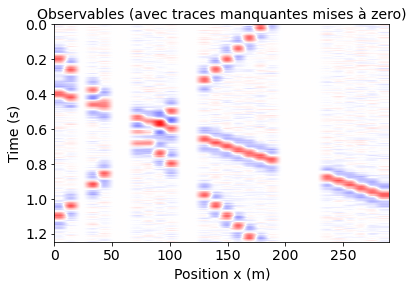

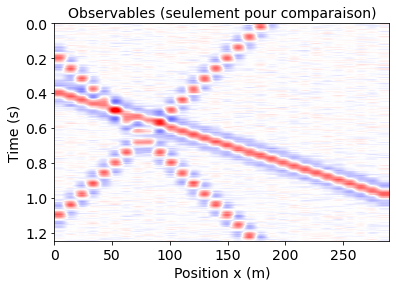

In [4]:
# Display of the input data
vmax    = np.max(np.abs(gpanel))
fig = plt.figure()
av = plt.subplot(111)
plt.imshow(gpanel,extent=[ax[0],ax[-1],at[-1],at[0]],aspect='auto')
plt.title('Observables (avec traces manquantes mises à zero)', fontsize = labelsize)
av.set_ylabel("Time (s)", fontsize = labelsize)
av.set_xlabel("Position x (m)", fontsize = labelsize)
av.tick_params(axis='both', which='major', labelsize=labelsize)
plt.clim([-vmax,vmax])
plt.set_cmap('bwr')

fig = plt.figure()
av = plt.subplot(111)
plt.imshow(panel_dense,extent=[ax[0],ax[-1],at[-1],at[0]],aspect='auto')
plt.title('Observables (seulement pour comparaison)', fontsize = labelsize)
av.set_ylabel("Time (s)", fontsize = labelsize)
av.set_xlabel("Position x (m)", fontsize = labelsize)
av.tick_params(axis='both', which='major', labelsize=labelsize)
plt.clim([-vmax,vmax])
plt.set_cmap('bwr')

# Question 1 : analyse des données dans le domaine de Fourier 2d
Représenter la transformée de Fourier 2d et bien préciser les axes. Indiquer à quoi correspond la fréquence maximale et le nombre d'onde maximal. Faire le lien entre les événements dans l'espace $(t,x)$ et ceux dans l'espace de Fourier. Expliquer ce qu'il se passe aux bords dans le domaine de Fourier. Ne pas hésiter à zoomer dans le domaine de Fourier.

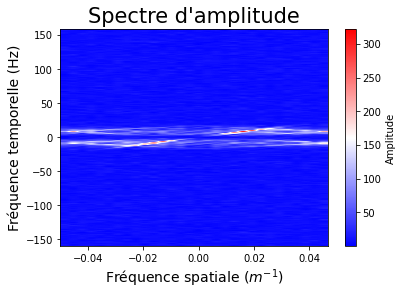

In [10]:
# calcul de la transformée de fourier
gpanelf = np.abs(np.fft.fftshift(np.fft.fft2(gpanel)))

# définition des axes
nf, nk = gpanel.shape

# axe vertical -- fréquence temporelle
af = np.fft.fftfreq(nf, d = dt)

# axe horizontal -- nombre d'onde (fréquence spatiale)
ak = np.fft.fftfreq(nk, d = dx)

# affichage de la transformé de fourier

fig = plt.figure()
av = plt.subplot(111)

plt.imshow(gpanelf,extent = [ak.min(), ak.max(), af.min(), af.max()], aspect = 'auto')

plt.title("Spectre d'amplitude", fontsize = 1.5*labelsize)

av.set_ylabel("Fréquence temporelle (Hz)", fontsize = labelsize)
av.set_xlabel("Fréquence spatiale ($m^{-1}$)", fontsize = labelsize)

cbar = plt.colorbar()
cbar.set_label("Amplitude")

Les fréquences spatiale et temporelle maximales représentent l'arrivée de l'onde sismique.

On voit que les basses et hautes fréquences temporelles à toutes les fréquences spatiales ont une amplitude importante : cela traduit la propagation de l'onde dans l'espace $(x, t)$. 

De plus, les fréquences temporelles sont centrées sur zéro, elles ne sont donc pas trop élevées et respectent le critère de Shannon (pas de recouvrement spectral)

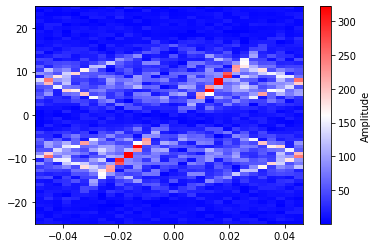

In [24]:
# zoom



fig = plt.figure()
av = plt.subplot(111)
plt.imshow(gpanelf, extent = [ak.min(), ak.max(), af.min(), af.max()],aspect = 'auto')

plt.ylim(-25, 25)

cbar = plt.colorbar()
cbar.set_label("Amplitude")

On observe néanmoins un repliement spectral pour le spectre spatial aux bords du domaine de Fourier : la fréquence spatiale d'échantillonage ne respecte donc pas le critère de Shannon.

# Question 2 : définition d'un masque dans le domaine de Fourier 2d
On note $f$ la fréquence et $k_x$ le nombre d'onde. Dans le domaine de Fourier 2d, on souhaite definir un masque avec des 1 qui couvrent les événements principaux. On va supposer que les événements dans le domaine $(t,x)$ sont linéaires. Montrer qu'il en est de même dans le domaine $(f,k_x)$. A partir de $(f,k_x)=(0,0)$, faire des sommations selon différentes pentes (dans le domaine de Fourier, apres avoir pris le module des valeurs complexes) et tracer la valeur de ces sommes en fonction de la pente. On s'attend à ce que 3 valeurs ressortent. Calculer une fonction qui sélectionne automatiquement ces valeurs et construire un masque dans le domaine de Fourier 2d qui vaut 1 autour de ces trois valeurs principales et 0 en dehors.

Par linéarité de la transformée de Fourier, les évènements dans le domaine $(f, k_x)$ sont donc également linéaires.

In [16]:
pentes = np.linspace(-np.pi/2+1e-3, np.pi/2-1e-3, 1000)

In [35]:
donnees = gpanelf[nt//2-nt//10 : nt//2 + nt//10] # on ne garde que la portion "pertinente" du spectre temporel

def moyenne(pente):
    x, y = donnees.shape
    x, y = x//2, y//2  #coordonnées du "curseur"
    
    # en fonction du signe de la pente, on emprunte la droite dans un sens particulier
    sens = 1
    if pente > 0:
        sens = -1
    if pente == 0:
        sens = 0
        
    somme = 0
    # en fonction de la pente, la somme comprendra plus ou moins de termes,
    # on veut se séparer de cette dépendance du nombre de termes
    nb_termes = 0
    
    while ((x >= 0) and (x < donnees.shape[0])):
        # on somme le terme "sur lequel on a le curseur"
        
        somme += donnees[x, y]
        nb_termes += 1
        
        x += sens # on "avance" dans la direction
        
        # pour l'ordonnée, le calcul est plus compliqué
        
        abs_y = int(donnees.shape[1]//2 + (donnees.shape[0]//2 - x)/np.tan(pente))
        
        if abs_y//donnees.shape[1] % 2 == 0: # nombre de repliements pair
            y = int(abs_y % donnees.shape[1])
        
        else :
            y = int(donnees.shape[1] - 1 - abs_y % gpanelf.shape[1])
            
    return somme/nb_termes, pente

Le programme précédent permet de calculer la somme pour une pente donnée

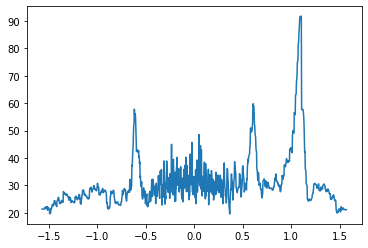

In [52]:
moyennes = np.vectorize(moyenne)(pentes)

plt.plot(moyennes[1], moyennes[0])

In [50]:
def pente_max(depart, arrivee):
    candidat = 0
    
    for i in range(arrivee - depart):
        
        if moyennes[0][depart:arrivee][i] > candidat:
            candidat = moyennes[0][depart:arrivee][i]
            res = moyennes[1][depart:arrivee][i + 1]
    return res
    

In [51]:
max1 = pente_max(200, 400)
max2 = pente_max(600, 750)
max3 = pente_max(800, 1000)

print(max1, max2, max3)

-0.61440476854535 0.6112620331563714 1.1015287538370595


In [62]:
masque = np.full(gpanelf.shape, False, dtype = bool)
pentes = [max1, max2, max3]

# on réutilise la méthode de "curseur"

for pente in pentes:
    x, y = gpanelf.shape[0]//2, gpanelf.shape[1]//2
    sens = 1
    
    if pente > 0:
        sens = -1
    
    while ((x >= 0) and (x < gpanelf.shape[0])):

        if y > 0:
            masque[x, y - 1] = True

        masque[x, y] = True

        if y < gpanelf.shape[1] - 1 :
            masque[x, y + 1] = True

        if y > 0:
            masque[-x, -y + 1] = True

        masque[-x, -y] = True

        if y < gpanelf.shape[1] - 1:
            masque[-x, -y - 1] = True

        x += sens

        abs_y = int(gpanelf.shape[1]//2 + (gpanelf.shape[0]//2 - x)/np.tan(pente))

        if abs_y//gpanelf.shape[1] % 2 == 0:
            y = int(abs_y % gpanelf.shape[1])

        else:
            y = int(gpanelf.shape[1] - 1 - abs_y % gpanelf.shape[1])

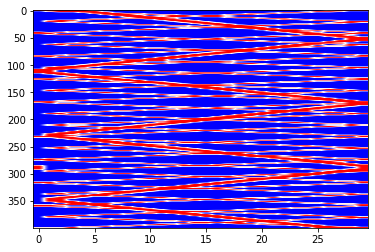

In [63]:
plt.imshow(masque, aspect = 'auto')

 # Question 3 : application du masque et analyse des résultats
Appliquer le masque (sur les données après transformée de Fourier 2d, sans prendre le module des valeurs), puis appliquer la transformée de Fourier inverse. Commenter les résultats (comparaison à la fois dans les domaines $(t,x)$ et $(f,k_x)$). Si nécessaire, revenir à la question 2 pour changer le masque et avoir une meilleure interpolation des données. Expliquer ces changements.

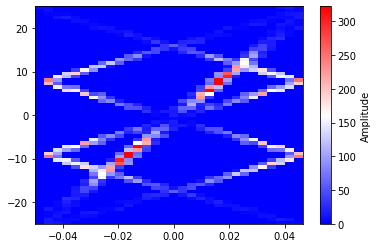

In [64]:
gpanelf_masque = masque * gpanelf

fig = plt.figure()
av = plt.subplot(111)
plt.imshow(gpanelf_masque, extent = [ak.min(), ak.max(), af.min(), af.max()],aspect = 'auto')

plt.ylim(-25, 25)

cbar = plt.colorbar()
cbar.set_label("Amplitude")

Le masque fait bien ressortir nos pentes principales.

# Question 4 : amélioration de l'approche 1
Le résultat de l'approche 1 montre en pratique que les données prédites après transformée de Fourier inverse 2d ne calent pas parfaitement aux données observées (pour les traces non nulles). C'est un inconvénient, mais d'un autre côté, ceci offre la possibilité d'aller plus loin forcer un bon calage.

Pour cela, nous définissons une fonction objective

$$
J[p] = \frac{1}{2}||T p - p^\mathrm{obs}||_2^2 + \frac{\alpha}{2} || F p ||_M^2
$$

où $p(t,x)$ sont les signaux (sur toutes les traces), $T$ l'operateur qui vaut 1 pour des traces existantes et 0 sinon, $p(t,x)^\mathrm{obs}$ les observables (i.e. pour les traces non nulles), $F$ la transformee de Fourier 2d. La norme $||p||_2^2 = \sum_x \sum_t |p(t,x)|^2$ et $||q||_M^2= \sum_x \sum_t M(f,k_x)|q(f,k_x)|^2$, avec $M$ un masque. Le poids $\alpha$ est une pondération entre les deux termes.

On cherche à minimiser $J$. Le meilleur $p$ sera celui qui minimise l'écart aux données (premier terme) tout en minimisant l'énergie dans le domaine de Fourier 2d. Par rapport au masque $M_0$ des questions 2 et 3, on prend ici $M=1 - M_0$. Expliquer pourquoi.

La minimisation se fait de manière iterative, avec la fonction ```minimize``` de scipy (```from scipy.optimize import minimize```). Parmi plusieurs possibilités, je suggère de prendre une approche de gradient conjugué (CG). La minisation va se faire selon :

```
res = minimize(defj, p0, method='CG', jac=defg, \
        options={'disp': True, 'maxiter':niter})
```

Il faut donc créer une valeur initiale pour $p$ (ici ```p0```), spécifier le nombre d'itérations ```niter``` et surtour définir la fonction objective ```defj()``` et son gradient par rapport à $p$ ```defg()```.

Le gradient est donné par 

$$
\frac{\partial J}{\partial p} = T^t(T p - p^\mathrm{obs}) + \alpha F^t M F p
$$

où $^t$ est l'opérateur transposée. L'application de $T^t$ correspond donc à insérer des traces nulles là où il n'y a pas d'observables et $F^t$ est la transformée de Fourier inverse.

Construire les fonctions ```defj()``` et ```defg()```. Attention, ```minimize``` attend que ```p``` soit sous forme de vecteur. On peut donc utiliser ```np.transpose(p,nt*nx)```.

$\alpha$ est une pondération dont la valeur est à tester (optimalement les deux termes ont a peu près la même valeur).

La valeur initiale ```p0``` de $p$ peut être prise égale à ```gpanel``` (le tableau lu au début du code).

Faire plusieurs itérations. Analyser les résultats à la fois dans le domaine temporel et dans le domaine de Fourier 2d. 

In [90]:
T = (gpanel != 0)

masque_negatif = 1 - masque

def trouver_alpha(alpha):
    
    def defj(p):
        """Definition of the objective function"""
        # Retrieve the size
        pan = np.reshape(p,[nt,nx])

        j0 = 0.5 * np.sum((T * pan - gpanel)**2) + alpha * 0.5 * np.sum(masque_negatif * np.abs(np.fft.fftshift(np.fft.fft2(pan)))**2)

        return j0


    def defg(p):
        """Definition of the gradient of the objective function"""
        # Retrieve the size
        pan = np.reshape(p,[nt,nx])
        
        grd = T *(T * pan - gpanel) + alpha * np.real(np.fft.ifft2(np.fft.ifftshift(masque_negatif * np.fft.fftshift(np.fft.fft2(pan)))))
        
        return grd.reshape(nt*nx)

    retour = minimize(defj, p0, method = 'cg', jac = defg, options = {'disp' : False, 'maxiter' : niter})
    
    return np.reshape(retour.x, [nt, nx])

In [91]:

niter = 10 # number of iterations
p0 = np.reshape(np.copy(gpanel),nt*nx)


alpha = 1e-10


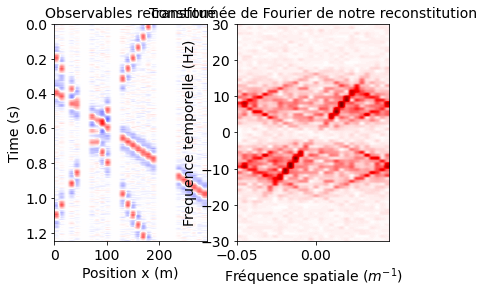

alpha = 1e-09


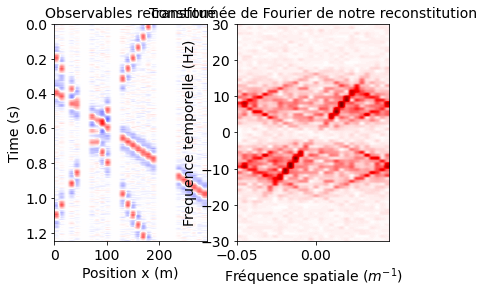

alpha = 1e-08


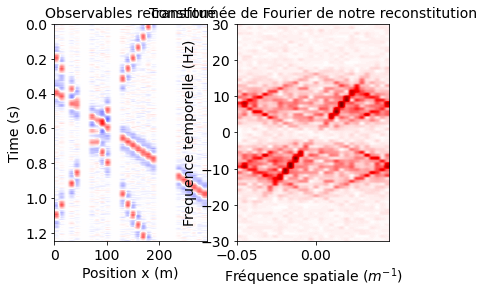

alpha = 1e-07


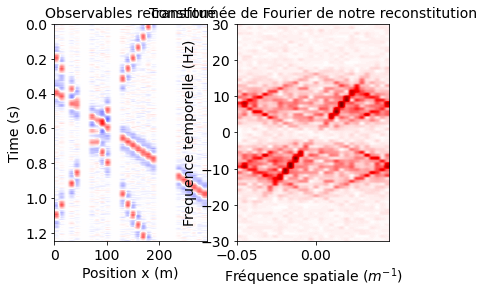

alpha = 1e-06


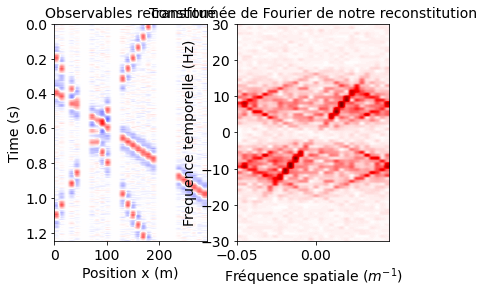

alpha = 1e-05


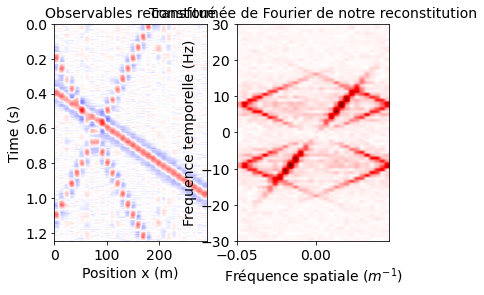

alpha = 0.0001


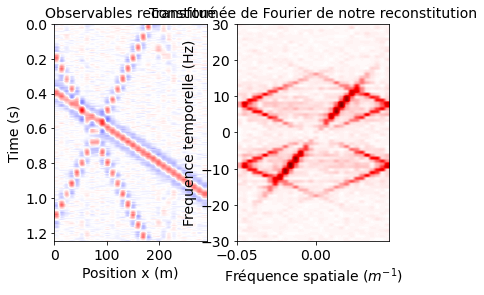

alpha = 0.001


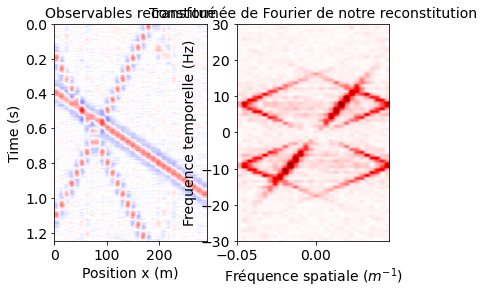

alpha = 0.01


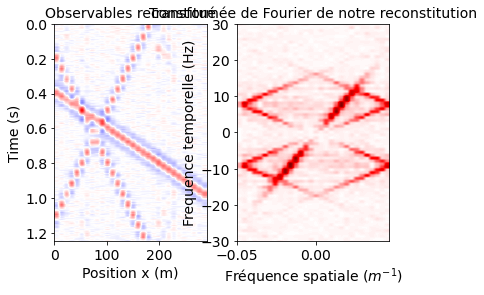

alpha = 0.1


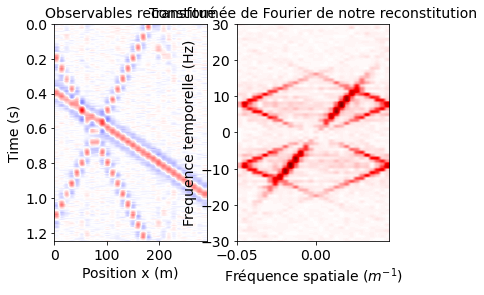

alpha = 1


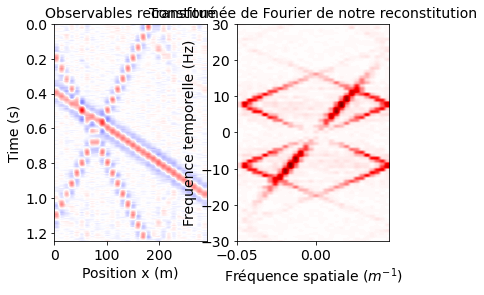

alpha = 10


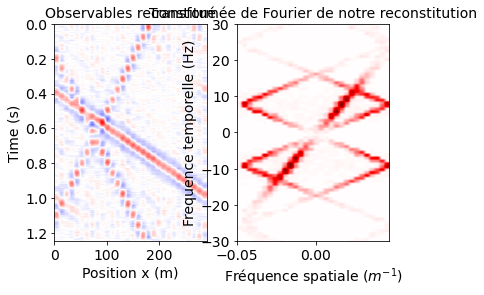

alpha = 100


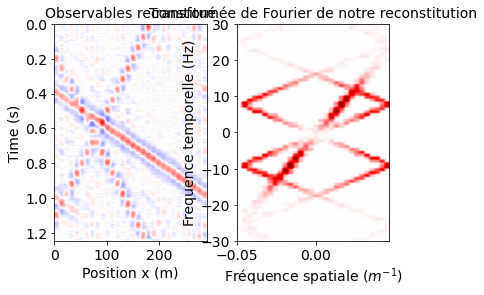

alpha = 1000


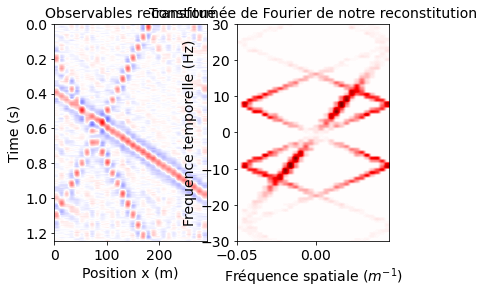

alpha = 10000


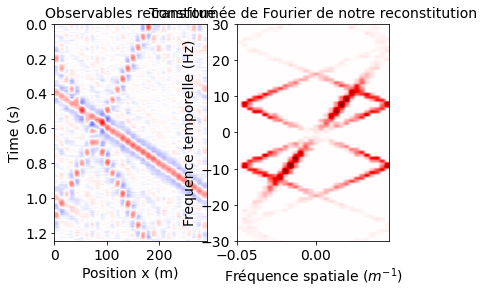

alpha = 100000


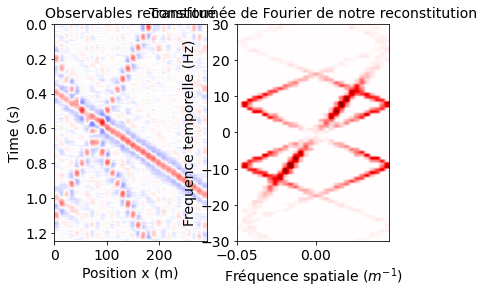

alpha = 1000000


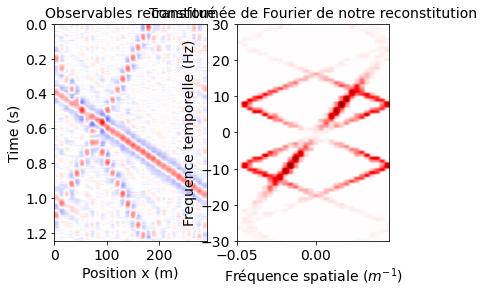

alpha = 10000000


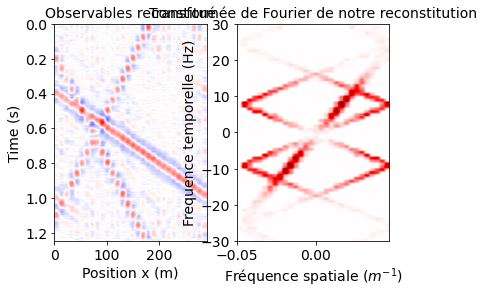

alpha = 100000000


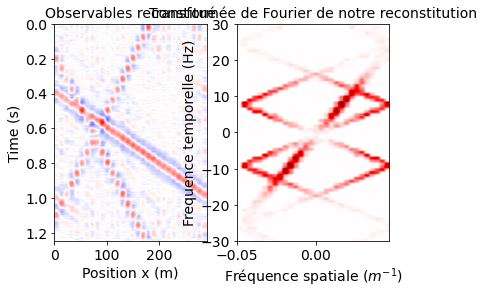

alpha = 1000000000


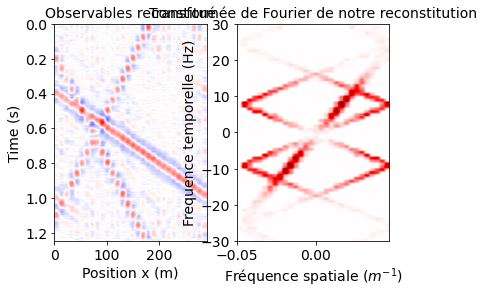

In [95]:
for i in range(-10, 10):
    print(f'alpha = {10**i}')
    
    gpanel2 = trouver_alpha(10**i)
    gpanelf2 = np.abs(np.fft.fftshift(np.fft.fft2(gpanel2)))
    
    # définition des axes
    nf, nk = gpanel.shape

    # axe vertical -- fréquence temporelle
    af = np.fft.fftfreq(nf, d = dt)

    # axe horizontal -- nombre d'onde (fréquence spatiale)
    ak = np.fft.fftfreq(nk, d = dx)
    
    fig = plt.figure()
    vmax = np.max(np.abs(gpanel2))
    
    
    av = plt.subplot(121)
    plt.imshow(gpanel2,extent=[ax[0],ax[-1],at[-1],at[0]],aspect='auto')
    plt.title('Observables reconstitué', fontsize = labelsize)
    av.set_ylabel("Time (s)", fontsize = labelsize)
    av.set_xlabel("Position x (m)", fontsize = labelsize)
    av.tick_params(axis='both', which='major', labelsize=labelsize)
    plt.clim([-vmax,vmax])
    plt.set_cmap('bwr')
    
    vmax = np.max(np.abs(gpanelf2))
    
    av2 = plt.subplot(122)
    plt.imshow(gpanelf2,extent=[ak.min(),ak.max(),af.min(),af.max()],aspect='auto', cmap = "seismic")
    plt.title('Transformée de Fourier de notre reconstitution', fontsize = labelsize)
    av2.set_ylabel("Frequence temporelle (Hz)", fontsize = labelsize)
    av2.set_xlabel("Fréquence spatiale ($m^{-1}$)", fontsize = labelsize)
    av2.tick_params(axis='both', which='major', labelsize=labelsize)
    plt.clim([-vmax,vmax])
    plt.ylim(-30, 30)
    
    plt.show()

In [96]:
alpha = 1e-3

def defj(p):
    """Definition of the objective function"""
    # Retrieve the size
    pan = np.reshape(p,[nt,nx])

    j0 = 0.5 * np.sum((T * pan - gpanel)**2) + alpha * 0.5 * np.sum(masque_negatif * np.abs(np.fft.fftshift(np.fft.fft2(pan)))**2)

    return j0


def defg(p):
    """Definition of the gradient of the objective function"""
    # Retrieve the size
    pan = np.reshape(p,[nt,nx])
        
    grd = T *(T * pan - gpanel) + alpha * np.real(np.fft.ifft2(np.fft.ifftshift(masque_negatif * np.fft.fftshift(np.fft.fft2(pan)))))
        
    return grd.reshape(nt*nx)

In [97]:
res = minimize(defj, p0, method='cg', 
                jac=defg, 
                options={'disp': True, 'maxiter':niter})
# Final panel
panelf = np.reshape(res.x,[nt,nx])

         Current function value: 607.755732
         Iterations: 8
         Function evaluations: 75
         Gradient evaluations: 63


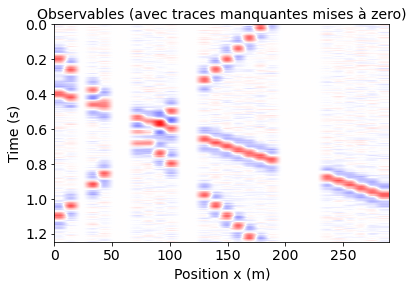

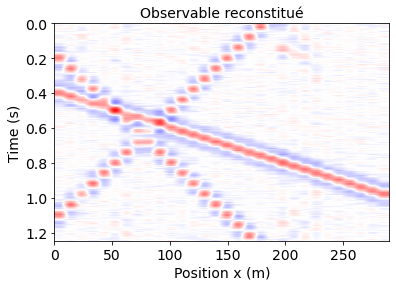

In [99]:
vmax    = np.max(np.abs(gpanel))
fig = plt.figure()
av = plt.subplot(111)
plt.imshow(gpanel,extent=[ax[0],ax[-1],at[-1],at[0]],aspect='auto')
plt.title('Observables (avec traces manquantes mises à zero)', fontsize = labelsize)
av.set_ylabel("Time (s)", fontsize = labelsize)
av.set_xlabel("Position x (m)", fontsize = labelsize)
av.tick_params(axis='both', which='major', labelsize=labelsize)
plt.clim([-vmax,vmax])
plt.set_cmap('bwr')




vmax    = np.max(np.abs(panelf))
fig = plt.figure()
av = plt.subplot(111)
plt.imshow(panelf,extent=[ax[0],ax[-1],at[-1],at[0]],aspect='auto')
plt.title('Observable reconstitué', fontsize = labelsize)
av.set_ylabel("Time (s)", fontsize = labelsize)
av.set_xlabel("Position x (m)", fontsize = labelsize)
av.tick_params(axis='both', which='major', labelsize=labelsize)
plt.clim([-vmax,vmax])
plt.set_cmap('bwr')

# Question 5 : analyse des limites de l'approche
Proposer une analyse des limites des approches 1 et 2, par exemple au travers d'applications sur des données bruitées, qui contiennent des événements qui ne sont pas linéaires, pourquoi pas sur des images dans un contexte très différent. **Cette dernière partie est très ouverte, et j'attends des investigations possiblement très variées.**
